# **Proyecto 03**: Sistemas de recomendación

Se va a implementar un **Sistema de Recomendación** para videojuegos de la plataforma Steam. Se van a utilizar dos datasets, uno que compila la información de los distintos videojuegos y otro referido a las críticas.

---
**INICIO**

---
Importamos las distintas librerías que se van a utilizar y los dos datasets.

---
Imports

In [60]:
import gzip
import itertools
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import re
import seaborn as sns

from implicit import evaluation
from implicit.als import AlternatingLeastSquares

from scipy import sparse
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.utils.random import sample_without_replacement

plt.style.use('ggplot')
sns.set()
sns.set_style("whitegrid")

---
Función *parse*

---

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## **Datasets**

Como se comento al principio, se trabajará con dos dataset distintos. Uno corresponde a las críticas y otro a los datos de los juegos.

El primer paso es cargar los mismos en memoria para tener un primer acercamiento a nuestros datos. Se sabe de ante mano que el tamaño de los mismos es algo que se debe tener en cuenta.

### Reviews

Importamos parte del dataset de las críticas. Analizamos en esta sección el dataset que contiene las críticas de los usuarios.

In [3]:
contador = 0
data_reviews = []

# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n=3,
# abrira uno de cada tres, y así.
n = 2
reviews_dir = '..\Proyecto III\steam_reviews.json.gz'
for l in parse(reviews_dir):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

Analizamos el dataset para ver con que nos encontramos. Mostramos diez registros al azar.

In [4]:
reviews = pd.DataFrame(data_reviews)
reviews.sample(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
1879348,paycethered,41.4,19.0,440,9,2017-09-03,fun game,False,1780,NaN,NaN,76561198375346703
1961463,Dugovics Titusz,796.5,22.0,440,3,2015-05-30,Its just a very nice and fun game for everyone,False,13820,NaN,NaN,76561198082010954
488738,ZerUniverse,6.0,126.0,399600,2,2016-07-02,It's an amazing game! I love the art style and...,False,2,NaN,NaN,NaN
1007576,PaulP,29.4,658.0,231140,6,2015-06-01,This game taught me how difficult it is to REA...,False,22,1.0,NaN,NaN
1727412,Timbo,5.1,722.0,282140,5,2016-08-16,"Pretty spoopy, pretty interesting games, basic...",False,410,NaN,NaN,NaN


Visualizamos un resumen de nuestro dataset.

In [68]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896535 entries, 0 to 3896534
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    object 
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 330.7+ MB


Como se visualiza, contamos con **3.896.535 registros** junto a **12 columnas**. A su vez, estamos ocupando más de **330 mb.** en memoria por lo que, al momento de realizar distintas consultas y análisis, vamos a notar bastante demora. Estás apreciaciones las realizo teniendo en cuenta las capacidades de mi PC.

Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [12]:
column = '\t | '
for name in reviews.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | username | hours | products | product_id | page_order | date | text | early_access | page | found_funny | compensation | user_id | 


In [5]:
reviews.drop(columns=['page_order', 'page', 'compensation', 'user_id'], inplace=True)
mapper = { 'username': 'Usuario', 'hours': 'Cant. horas', 'products' : 'Cant. juegos', 'found_funny': 'Divertido?',
           'early_access': 'Acceso previo', 'date': 'Fecha', 'text': 'Comentario',
           'product_id': 'GameID' }
reviews.rename(columns=mapper, inplace=True)
reviews = reviews.reindex(columns=['Usuario', 'Cant. horas', 'Cant. juegos', 'Acceso previo', 'Fecha', 'Comentario',
                                   'Divertido?', 'GameID'])
reviews.head()

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,Divertido?,GameID
0,Chaos Syren,0.1,41.0,False,2017-12-17,This would not be acceptable as an entertainme...,NaN,725280
1,hello?<,14.6,2.0,False,2017-10-16,Better than Minecraft,2.0,328100
2,DarklyThinking,16.6,577.0,False,2018-01-04,Still worth playing in 2018.\nProbably my favo...,NaN,35140
3,nd,1.0,2759.0,False,2017-11-28,"endless rooms of some underground complex, blo...",1.0,725280
4,jimllfixitok,1.1,729.0,False,2017-10-16,no sound. icons don't work. re-installed but n...,NaN,707610


Nuestro dataset es más claro y legible al momento de visualizar los registros. Cambiamos el tipo de datos de algunos atributos y visualizamos los valores nulos.

In [6]:
reviews['Acceso previo'] = reviews['Acceso previo'].astype('category')
reviews['Comentario'] = reviews['Comentario'].astype('string')
reviews['Fecha'] = pd.to_datetime(reviews['Fecha'])
reviews['GameID'] = reviews['GameID'].astype('int32')
reviews['Usuario'] = reviews['Usuario'].astype('string')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896535 entries, 0 to 3896534
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Usuario        string        
 1   Cant. horas    float64       
 2   Cant. juegos   float64       
 3   Acceso previo  category      
 4   Fecha          datetime64[ns]
 5   Comentario     string        
 6   Divertido?     float64       
 7   GameID         int32         
dtypes: category(1), datetime64[ns](1), float64(3), int32(1), string(2)
memory usage: 196.9 MB


Las siguientes columnas tienen valores nulos:
	Cant. horas tiene 13206 datos nulos (0.34%).
	Cant. juegos tiene 7531 datos nulos (0.19%).
	Divertido? tiene 3296831 datos nulos (84.61%).



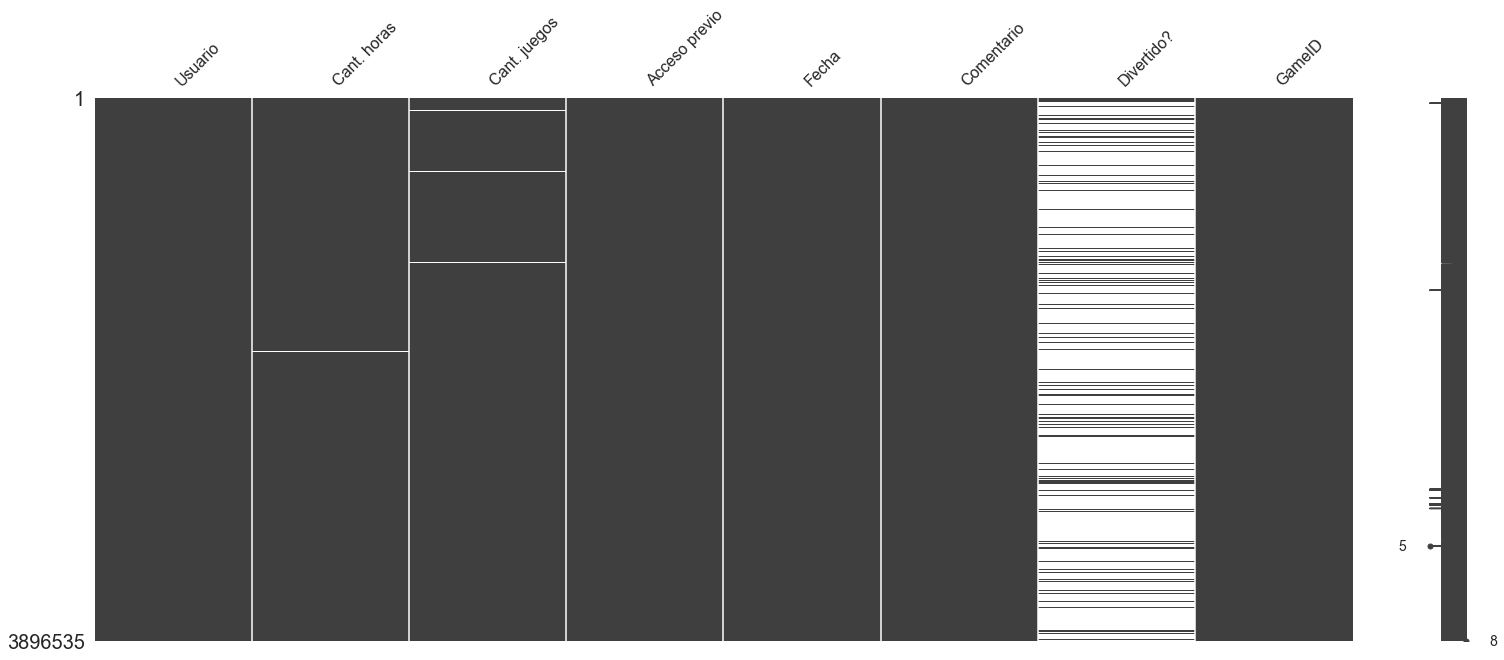

In [7]:
column = ''
for i in reviews.columns:
    if reviews[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = reviews[i].isna().sum()
        total = len(reviews)
        porcentaje = round(100*cantidad/total, 2)
        column += f'\t{ i } tiene { reviews[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.matrix(reviews)
plt.show()

Como se puede observar, existen valores nulos, pero, teniendo en cuenta la cantidad de registros que tenemos, no representan un porcentaje importante en nuestro dataset; tenemos menos del 1% de valores faltantes.

### Games

Finalizado este primer acercamiento con el dataset de críticas, importamos nuestros datos que contienen información sobre los juegos.

In [7]:
data_games = []
games_dir = '..\Proyecto III\steam_games.json.gz'
for games in parse(games_dir):
    data_games.append(games)
#games = pd.read_json(games_dir, compression='gzip', lines=False, orient='split', typ='series')

Analizamos el dataset de videojuegos, mostramos diez registros al azar.

In [8]:
games = pd.DataFrame(data_games)
games.sample(10)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
29758,Songquito UG,"[Casual, Indie, Simulation]",Songs2See,Songs2See,http://store.steampowered.com/app/248270/Songs...,2013-11-26,"[Indie, Simulation, Casual, Music, Education]",NaN,http://steamcommunity.com/app/248270/reviews/?...,[Single-player],14.99,False,248270,Songquito UG,Mixed,NaN
30803,Stardock Entertainment,[Strategy],Galactic Civilizations® I: Ultimate Edition,Galactic Civilizations® I: Ultimate Edition,http://store.steampowered.com/app/214150/Galac...,2012-08-14,"[Strategy, 4X, Space, Sci-fi, Turn-Based, Turn...",NaN,http://steamcommunity.com/app/214150/reviews/?...,[Single-player],9.99,False,214150,Stardock Entertainment,Mixed,83
5934,Idea Factory International,[Strategy],Hyperdevotion Noire: Ultimate Resta Set,Hyperdevotion Noire: Ultimate Resta Set,http://store.steampowered.com/app/426926/Hyper...,2016-04-26,[Strategy],NaN,http://steamcommunity.com/app/426926/reviews/?...,"[Single-player, Downloadable Content, Full con...",0.99,False,426926,"Idea Factory,Compile Heart,Sting",1 user reviews,NaN
28182,Pinkerton Road Studio,[Adventure],Gabriel Knight - Sins of the Fathers Demo,Gabriel Knight - Sins of the Fathers Demo,http://store.steampowered.com/app/318170/Gabri...,2014-10-20,[Adventure],NaN,http://steamcommunity.com/app/318170/reviews/?...,"[Single-player, Game demo, Steam Achievements,...",NaN,False,318170,"Phoenix Online Studios,Pinkerton Road Studio",7 user reviews,NaN
22994,Alexey Roenko,"[Action, Adventure, Indie]",Dungeon Escape,Dungeon Escape,http://store.steampowered.com/app/454100/Dunge...,2016-05-27,"[Indie, Action, Platformer, Adventure, Difficu...",NaN,http://steamcommunity.com/app/454100/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",3.99,False,454100,Alexey Roenko,Mostly Positive,NaN
1146,"Black Forest Games, THQ Nordic","[Action, Indie]",Giana Sisters: Twisted Dreams,Giana Sisters: Twisted Dreams,http://store.steampowered.com/app/223220/Giana...,2012-10-22,"[Platformer, Indie, Action, Female Protagonist...",NaN,http://steamcommunity.com/app/223220/reviews/?...,"[Single-player, Multi-player, Shared/Split Scr...",14.99,False,223220,Black Forest Games,Very Positive,77
6850,Nomad Games,"[Indie, RPG, Strategy]",Talisman - The Blood Moon Expansion,Talisman - The Blood Moon Expansion,http://store.steampowered.com/app/267788/Talis...,2016-08-04,"[Strategy, RPG, Indie]",NaN,http://steamcommunity.com/app/267788/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",4.99,False,267788,Nomad Games,Mixed,NaN
23813,Kurechii,"[Adventure, Indie, Strategy]",Tiny Guardians,Tiny Guardians,http://store.steampowered.com/app/431230/Tiny_...,2016-03-24,"[Indie, Strategy, Adventure, Tower Defense]",NaN,http://steamcommunity.com/app/431230/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,431230,Kurechii,Positive,NaN
7981,Devolver Digital,"[Action, Indie, Early Access]",Genital Jousting,Genital Jousting,http://store.steampowered.com/app/469820/Genit...,2016-11-17,"[Early Access, Sexual Content, Nudity, Multipl...",NaN,http://steamcommunity.com/app/469820/reviews/?...,"[Online Multi-Player, Local Multi-Player, Shar...",4.99,True,469820,Free Lives,Very Positive,NaN
17665,NaN,NaN,Deep Blue 3D Maze,NaN,http://store.steampowered.com/app/484830/Deep_...,NaN,"[Adventure, Action, Casual, Indie, VR, Puzzle,...",NaN,http://steamcommunity.com/app/484830/reviews/?...,"[Single-player, Steam Achievements, Full contr...",2.99,False,484830,NaN,Positive,NaN


Visualizamos un resumen de nuestro dataset.

In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


En este dataset contamos con 321.355 registros junto a 16 columnas. Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [152]:
column = '\t | '
for name in games.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | publisher | genres | app_name | title | url | release_date | tags | discount_price | reviews_url | specs | price | early_access | id | developer | sentiment | metascore | 


In [9]:
columns = ['id', 'app_name', 'developer', 'title', 'release_date', 'genres', 'specs', 'tags', 'url', 'early_access',
           'sentiment', 'metascore']
games.drop(columns=['discount_price', 'publisher', 'reviews_url', 'title'], inplace=True)

mapper = { 'id': 'GameID', 'app_name': 'Aplicación', 'developer': 'Desarrollador', 'release_date': 'Fecha lanzamiento',
           'genres': 'Géneros', 'specs': 'Especificaciones', 'tags': 'Etiquetas', 'url': 'Url',
           'early_access': 'Acceso previo', 'price': 'Precio', 'sentiment': 'Sentimiento', 'metascore': 'Metascore' }
games.rename(columns=mapper, inplace=True)
games = games.reindex(columns=['GameID', 'Aplicación', 'Desarrollador', 'Fecha lanzamiento', 'Géneros',
                               'Especificaciones', 'Etiquetas', 'Url', 'Acceso previo', 'Precio', 'Sentimiento',
                               'Metascore'])
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",http://store.steampowered.com/app/761140/Lost_...,False,4.99,NaN,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",http://store.steampowered.com/app/643980/Ironb...,False,Free To Play,Mostly Positive,NaN
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",http://store.steampowered.com/app/670290/Real_...,False,Free to Play,Mostly Positive,NaN
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",http://store.steampowered.com/app/767400/2222/,False,0.99,NaN,NaN
4,773570,Log Challenge,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN,NaN


Cambiamos el tipo de datos de algunos atributos y visualizamos los valores nulos.

In [10]:
print(f'Shape: { games.shape }\n', )
games['Aplicación'] = games['Aplicación'].astype('string')
games['Desarrollador'] = games['Desarrollador'].astype('string')
games['Url'] = games['Url'].astype('string')
games.info(verbose=True)

Shape: (32135, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GameID             32133 non-null  object
 1   Aplicación         32133 non-null  string
 2   Desarrollador      28836 non-null  string
 3   Fecha lanzamiento  30068 non-null  object
 4   Géneros            28852 non-null  object
 5   Especificaciones   31465 non-null  object
 6   Etiquetas          31972 non-null  object
 7   Url                32135 non-null  string
 8   Acceso previo      32135 non-null  bool  
 9   Precio             30758 non-null  object
 10  Sentimiento        24953 non-null  object
 11  Metascore          2677 non-null   object
dtypes: bool(1), object(8), string(3)
memory usage: 2.7+ MB


Las siguientes columnas tienen valores nulos:
	GameID tiene 2 datos nulos (0.01%).
	Aplicación tiene 2 datos nulos (0.01%).
	Desarrollador tiene 3299 datos nulos (10.27%).
	Fecha lanzamiento tiene 2067 datos nulos (6.43%).
	Géneros tiene 3283 datos nulos (10.22%).
	Especificaciones tiene 670 datos nulos (2.08%).
	Etiquetas tiene 163 datos nulos (0.51%).
	Precio tiene 1377 datos nulos (4.29%).
	Sentimiento tiene 7182 datos nulos (22.35%).
	Metascore tiene 29458 datos nulos (91.67%).



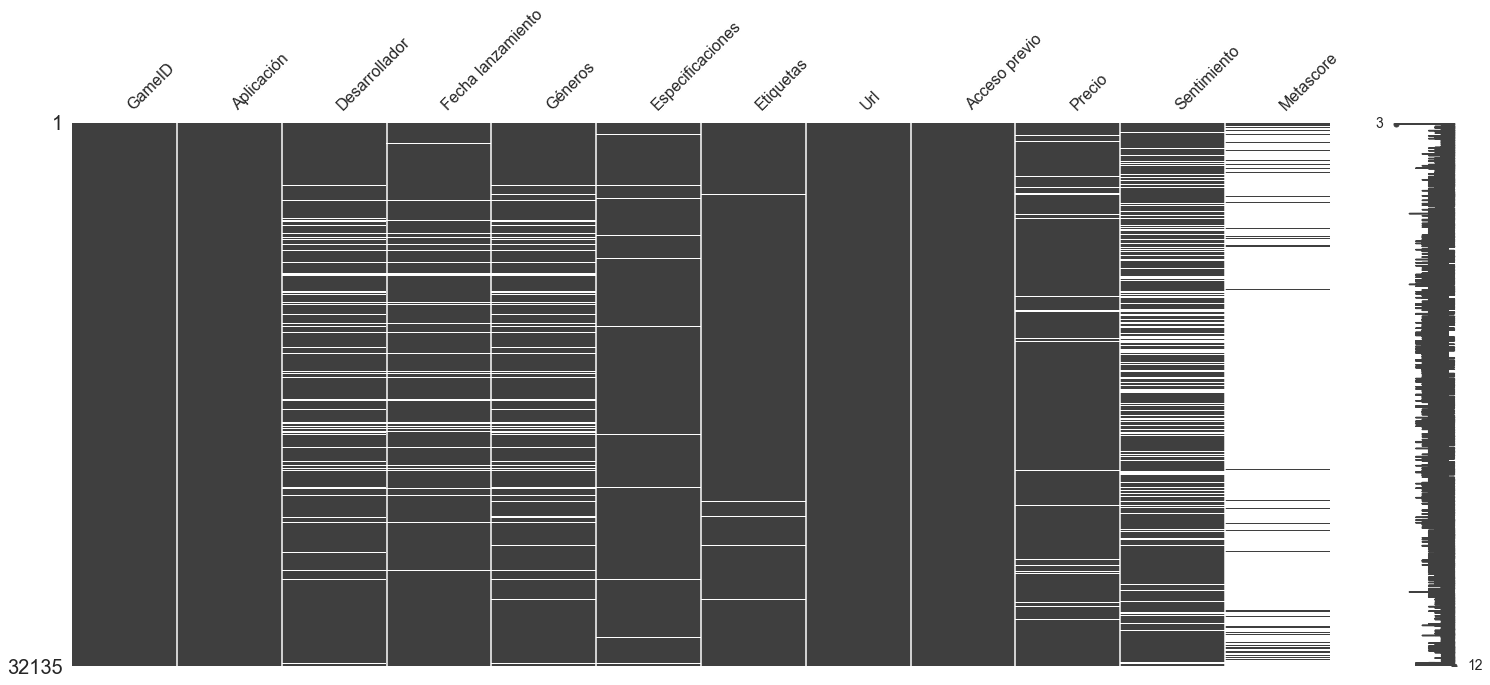

In [6]:
column = ''
for i in games.columns:
    if games[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = games[i].isna().sum()
        total = len(games)
        porcentaje = round(cantidad*100/total, 2)
        column += f'\t{ i } tiene { games[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.matrix(games)
plt.show()

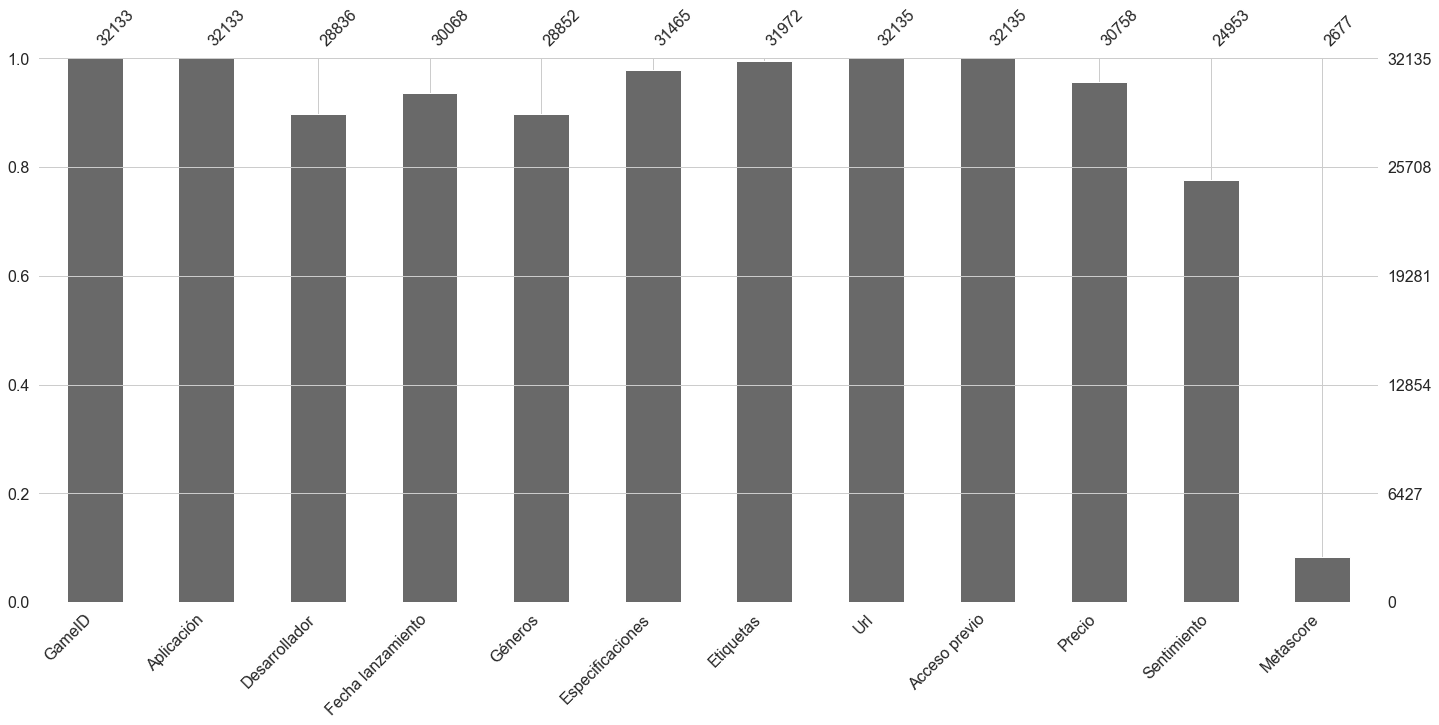

In [156]:
msno.bar(games)
plt.show()

Como se puede observar, existe mucha presencia de valores faltantes. El atributo ```Metascore``` tiene más del 90% de los registros como valores nulos y el atributo ```Sentimiento``` posee más del 20%.

## **Preprocesamiento**

El dataset correspondiente a la información de los videojuegos es el que necesita un preprocesamiento en los datos y el dataset de los comentarios no presenta mayores problemas. De todos modos se hacen algunos ajustes en el mismo.

### Reviews

#### Duplicados

En esta sección vamos a analizar tanto la presencia de registros duplicados como la presencia de varios comentarios (más de uno) que un mismo usuario realiza sobre un juego. En primer lugar, buscamos los registros duplicados y analizamos los mismos.

In [25]:
mask = reviews.duplicated()
reviews[mask].sample(5)

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
3504446,SpaceLegend77,43.3,7.0,False,2017-02-25,Excelent coop game,49520
2127682,Wong D,18.0,58.0,False,2015-02-16,I know a lot of people say that this game is j...,273350
3794284,taskmgr.exe,409.0,82.0,True,2017-04-04,"Alright, DayZ. Despite all the bugs and all th...",221100
740685,[FL:RP] Ryan :),1748.1,5.0,False,2017-06-16,Great game cheap for the amount of fun if you ...,4000
1184683,MyTenacity,54.3,156.0,False,2016-05-14,Sadly I have to redo my review o fthis game. I...,377160


In [26]:
print(f'Existen { reviews[mask].shape[0] } registros duplicados.')

Existen 215303 registros duplicados.


Como se puede observar, existen **215.303 datos duplicados** en nuestro dataset. Investigamos un usuario al azar.

In [14]:
name = 'Kabuto'
reviews.query('Usuario == @name')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
2458289,Kabuto,27.3,260.0,False,2017-09-12,"Very fun game, good variety of characters all ...",402570
3433850,Kabuto,28.3,32.0,False,2015-09-09,Best COD ever created,10180
3433938,Kabuto,28.3,32.0,False,2015-09-09,Best COD ever created,10180


Como se observa, existen *dos comentarios que realizó el usuario **Kabuto** sobre el juego 10.180*; también se verifica que la fecha como el comentario realizado es el mismo. Eliminamos los duplicados y vemos cantidad de usuarios y de juegos a analizados.

In [11]:
reviews.drop_duplicates(inplace=True)
print('Registros finales:', reviews.shape[0])
print("Total de juegos:", reviews.GameID.value_counts().count())
print("Total de usuarios:", reviews.Usuario.value_counts().count())

Registros finales: 3681242
Total de juegos: 14970
Total de usuarios: 1716724


---
COMENTARIOS DUPLICADOS

---

Como se observó previamente, existían registros duplicados. Si realizamos la misma búsqueda de registros duplicados, pero, solamente teniendo en cuenta los usuarios y el juego, nos vamos a encontrar con lo siguiente:

In [40]:
mask = reviews.duplicated(subset=['Usuario', 'GameID'])
print(f"Existen { reviews[mask].shape[0] } comentarios que un usuario realizó en un mismo videojuego.")
reviews[mask].sample(5)

Existen 26512 comentarios que un usuario realizó en un mismo videojuego.


,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
358910,Victor Saltzpyre,67.9,148.0,False,2015-10-23,Left4Dead set in the warhammer universe with M...,235540
2316193,Spooky,89.2,31.0,False,2013-12-02,Best sandbox action game ever!,8190
3282719,Batman,197.0,60.0,False,2016-01-27,"It's like Monopoly, it'll ruin your friendships.",8930
1892870,Ape,2728.6,40.0,False,2015-06-01,Game of my life. No game in the history of man...,107410
1942050,Kevin,307.2,26.0,False,2016-01-24,Good game!!!!!,440


Tomamos un usuario al azar y corroboramos que el mismo usuario comento más de una vece un videojuego.

In [41]:
name = 'Ori'
reviews.query('Usuario == @name & GameID == 261570')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
1219825,Ori,15.2,40.0,False,2016-12-02,best game i habe played .,261570
1279710,Ori,12.6,151.0,False,2015-06-25,Best 2D Jump n Run Game. Period! !!!!! Forlorn...,261570


En estos casos, la metodología que se eligió fue eliminar aquellos comentarios que sean más antiguos, de este modo, nos quedamos con el último comentario realizado por el usuario, osea, nos quedamos con la última impresión del usuario sobre el juego.

In [12]:
reviews = reviews.sort_values(by='Fecha', ascending=False).drop_duplicates(subset=['Usuario', 'GameID'])

Verificamos el resultado con el usuario **Ori** y el mismo juego **261.570**.

In [13]:
name = 'Ori'
reviews.query('Usuario ==  @name & GameID == 261570')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,Divertido?,GameID
1219825,Ori,15.2,40.0,False,2016-12-02,best game i habe played .,NaN,261570


Finalmente, visualizamos la cantidad de registros.

In [77]:
print('Registros finales:', reviews.shape[0])

Registros finales: 3654720


#### Valores faltantes

Respecto a los valores faltantes de nuestro dataset corresppondiente a las críticas, se procede directamente a la eliminación de aquellos registros nulos. De un universo de 3.896.535 registros, sólo 20.737 tienen valores faltantes; la eliminación de los mismos no implica una pérdida de datos significativa.

In [33]:
reviews.isna().sum()

Usuario              0
Cant. horas      13079
Cant. juegos      7230
Acceso previo        0
Fecha                0
Comentario           0
GameID               0
dtype: int64

Una solución al problema podría ser el relleno de los mismos con el promedio de horas jugadas. Podríamos hacer algo así:

In [34]:
reviews['Cant. horas'].fillna(reviews.groupby('Usuario')['Cant. horas'].transform('mean'), inplace=True)

De todos modos, podemos observar que no se realizaron algunas imputaciones.

In [236]:
reviews.query('`Cant. horas`.isna()', engine='python').sample(5)

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
2882950,Realnazty,NaN,19.0,False,2015-05-31,"Hitler, vikings, dinosaurs and kung fu... what...",374570
385630,Ninja dos Bunnyhop,NaN,89.0,False,2018-01-04,The lack of a seccond analog stick is a proble...,353370
437104,blackout2k,NaN,16.0,False,2016-02-21,Does this controller work with mac?,353370
2687183,CrAsHeR X GaMeR,NaN,11.0,False,2017-11-16,LOL That's cool music. :D,540070
3586231,[bic]CaptainMiller,NaN,202.0,False,2011-02-12,Direct-Tank-Control!,20540


In [29]:
reviews.loc[3586231, :]

Usuario            [bic]CaptainMiller
Cant. horas                       NaN
Cant. juegos                    202.0
Acceso previo                   False
Fecha             2011-02-12 00:00:00
Comentario       Direct-Tank-Control!
GameID                          20540
Name: 3586231, dtype: object

Investigamos un usuario al azar para ver que ocurre.

In [237]:
username = 'n4p4l44'
reviews.query('Usuario == @username')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
385594,n4p4l44,NaN,38.0,False,2018-01-05,I chose to buy the Steam Controller over an XB...,353370


Como se puede observar, este usuario solamente hizo un solo comentario de un juego y ningún comentario más. Por lo tanto, no obtenemos un promedio de horas. En estos casos, rellenamos con el promedio de horas que tiene el juego.

In [11]:
reviews['Cant. horas'].fillna(reviews.groupby('GameID')['Cant. horas'].transform('mean'), inplace=True)
reviews.isna().sum()

Usuario             0
Cant. horas         7
Cant. juegos     7113
Acceso previo       0
Fecha               0
Comentario          0
GameID              0
dtype: int64

Solamente nos quedaron 7 registros sin poder completar.

In [243]:
reviews[reviews['Cant. horas'].isna()]

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
3087215,yannick034,NaN,70.0,False,2017-12-31,How do we use it,666200
287111,OGK_Demipimp,NaN,109.0,False,2017-12-18,Its a text file in your gamefolder I like to t...,538610
531091,tinaellie2,NaN,163.0,False,2017-11-08,Yikes...This game has issues. Not just glitche...,436430
1819096,Celtic Dragon,NaN,9.0,False,2017-06-23,Now without the rule of three I think this is ...,545740
1425747,Beil Bostoob,NaN,543.0,False,2016-05-31,This soundtrack changed my life 10/10,407400
1353961,String_Relativity,NaN,15.0,False,2016-05-05,"5 Bosses and 52 new levels. Now costs $5, but ...",461200
2363403,DamagedYT,NaN,34.0,False,2015-12-18,I cant Actually Run this Like i have the Files...,419640


Estos corresponden a juegos donde solo tenemos un comentario los cuales corresponde a usuarios sin horas registradas. Procedemos a eliminar estos valores faltantas.

In [12]:
reviews.query('GameID == "666200"')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
3087215,yannick034,NaN,70.0,False,2017-12-31,How do we use it,666200


In [15]:
reviews.dropna(axis=0, subset=['Cant. horas', 'Cant. juegos'], inplace=True)
reviews['Cant. horas'] = reviews['Cant. horas'].astype('float32')
reviews['Cant. juegos'] = reviews['Cant. juegos'].astype('uint32')
reviews.drop(columns='Divertido?', inplace=True)
reviews.isna().sum()

Usuario          0
Cant. horas      0
Cant. juegos     0
Acceso previo    0
Fecha            0
Comentario       0
GameID           0
dtype: int64

###  Games

#### Duplicados

Empezamos con este análisis preliminar de duplicados buscando valores que se repitan a groso modo. Más adelante entraremos en un detalle realizando un análisis más profundo.

In [157]:
duplicados = len(games[games.drop(columns=['Especificaciones', 'Etiquetas','Géneros']).duplicated()])
print(f'Total de registros duplicados: { duplicados }')

Total de registros duplicados: 0


En está primer acercamiento, parece ser que no existen registros duplicados. Si analizamos las columnas que conforman dicho dataset nos encontramos que contamos con campos en los cuales difícilmente sean similares con otros registros. Por ejemplo, el atributo ```GameID``` es identificador único entre los distintos registros, a su vez, este mismo campo tiene influencia en el atributo ```Url``` ya que en la misma podemos encontrar dicho valor.

In [158]:
games.loc[1068, ['GameID', 'Aplicación', 'Url']]

GameID                                                   200260
Aplicación       Batman: Arkham City - Game of the Year Edition
Url           http://store.steampowered.com/app/200260/Batma...
Name: 1068, dtype: object

Como se puede verificar, en el campo *Url* se encuentra el GameID del juego. Si elegimos incorrectamente las columnas no vamos a encontrar registros duplicados. En este caso, se van a elegir los siguientes atributos: ```Aplicación```, ```Desarrollador```

In [184]:
games[games.loc[:,['Aplicación', 'Desarrollador']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN
4440,401200,Invisible Apartment 2,"Milan Kazarka,Jeroen van Oosten",2015-09-24,"[Adventure, Indie]",[Single-player],"[Adventure, Indie, Visual Novel, Anime, Hackin...",http://store.steampowered.com/app/401200/Invis...,False,7.99,4 user reviews,NaN
8117,529700,Total Extreme Wrestling,Grey Dog Software,2016-12-02,[Sports],[Single-player],"[Sports, Wrestling, Management]",http://store.steampowered.com/app/529700/Total...,False,19.99,Positive,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13155,773080,MORE SWEATER? OK!,Triple-Star Studio,2017-12-19,"[Casual, Indie, Simulation]","[Single-player, Downloadable Content, Steam Ac...","[Indie, Casual, Simulation]",http://store.steampowered.com/app/773080/MORE_...,False,0.99,NaN,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN


Como podemos visualizar, existen varios registros duplicados. En algunos de ellos se repite el atributo ```GameID```, en otros no pero varian los campos de otras columnas; también, nos encontramos con juegos donde la *fecha de lanzamiento* y el *nombre de la aplicación* del son equivalentes.

Sí nos basamos únicamente en el nombre vamos a encontrar muchos juegos con el mismo nombre pero distinto desarrollador. Sí buscamos juegos con el mismo nombre, el mismo desarrollador y la misma fecha de lanzamiento nos vamos a encontrar con algunos registros donde el nombre del desarrollador es distinto.

De acuerdo a la selección de columnas varían los duplicamos. Lo vemos a continuación:

In [160]:
print(f'Existen { len(games[games["Aplicación"].duplicated()]) } juegos duplicados por nombre.')
print(f'Existen { len(games[games[["Aplicación", "Desarrollador"]].duplicated()]) } juegos duplicados por nombre y desarrollador.')
print(f'Existen { len(games[games[["Aplicación", "Desarrollador", "Fecha lanzamiento"]].duplicated()]) } juegos duplicados por nombre, desarrollador y fecha.')

Existen 40 juegos duplicados por nombre.
Existen 9 juegos duplicados por nombre y desarrollador.
Existen 5 juegos duplicados por nombre, desarrollador y fecha.


Nos vamos a centrar en aquellos registros duplicados donde comparten el **nombre** y la **fecha de lanzamiento**.

In [161]:
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN
13894,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/,False,59.99,Mostly Positive,86
14573,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/Wolfe...,False,59.99,Mostly Positive,86
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews,55
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed,55
30178,224850,Aliens: Colonial Marines - Reconnaissance Pack,Gearbox Software,2013-05-07,[Action],"[Single-player, Multi-player, Co-op, Downloada...",[Action],http://store.steampowered.com/app/224850/Alien...,False,NaN,NaN,NaN


Al ser pocos registros, se realizo una búsqueda por internet sobre los distintos registros y se encontró lo siguiente:

* **Aliens: Colonial Marines - Reconnaissance Pack**: Mismo artículo, url indica diferencia según país.
* **Batman: Arkham City - Game of the Year Edition**: Mismo artículo, solo uno tiene ```GameID```, se verifica en la url que es la misma en los dos registros.
* **Escape room**: Son dos juegos distintos.
* **The Dream Machine: Chapter 4**: El válido corresponde al siguiente ```GameID```: 94.304.
* **Warhammer Quest**: Uno corresponde a un juego y el otro a DLC (mismo árticulo, el campo desarrollador difiere).
* **Wolfenstein II: The New Colossus**: Difiere la ```Url``` pero corresponden al mismo juego.

Al ser pocos juegos duplicados sin posibilidad de filtrar el correcto se hace una eliminación manual. Los siguientes registros se eliminan: 30961, 30178, 13894, 1508.

In [16]:
games.drop([30961, 30178, 13894, 1508], axis=0, inplace=True)
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews,55
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed,55


A estos registros se los corrige para que sean acordes a la información que se extrae de la plataforma steam.

In [17]:
# Escape Room
games.loc[10350,'Desarrollador'] = 'AppFactoryHaru-Ni'
games.loc[10350,'Fecha lanzamiento'] = '2017-06-30'

games.loc[13421,'Desarrollador'] = 'OneTechAsia'
games.loc[13421,'Fecha lanzamiento'] = '2017-12-11'
# Warhammer Quest
games.loc[27671,'Desarrollador'] = 'Rodeo Games,Twistplay'

#### Valores faltantes

> **ACLARACIÓN**:
Descartamos del análisis las columnas ```Desarrollador```, ```Fecha lanzamiento```, ```Metascore```,  y ```Sentimiento``` ya que son las que destacan en valores nulos y no considero relevante su uso al momento de realizar el sistema de recomendación. Si las etiquetas ```Metascore```,  y ```Sentimiento``` tuviesen más datos sería un aporte sideral para la finalidad de nuestro proyecto. Recordemos que **Metascore tiene 29458 datos nulos (91.67%)** y **Sentimiento** tiene 7182 datos nulos (22.35%).

Analizamos los valores nulos de nuestro dataset correspondiente a los juegos. Nos vamos a enfocar en los siguientes atributos: ```GameID```, ```Aplicación```, ```Géneros```, ```Especificaciones```, ```Etiquetas```, ```Precio```.

In [220]:
games.isna().sum()

GameID                   1
Aplicación               2
Desarrollador         3297
Fecha lanzamiento     2065
Géneros               3283
Especificaciones       670
Etiquetas              163
Url                      0
Acceso previo            0
Precio                1376
Sentimiento           7180
Metascore            29456
dtype: int64

---
**GameID y Aplicación**

---
Buscamos los nulos de ```GameID``` y ```Aplicación``` ya que ellas mismas nos ayudan a entender que juego estamos analizando a través del nombre y del identificador.

In [165]:
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN


Podemos corroborar que el registro 74 comparte nulidad en ```GameID``` y ```Aplicación```. Prodecemos a eliminarlo y vamos a tratar de completar los datos faltantes de los otros registros. 

In [18]:
games.drop([74], axis=0, inplace=True)
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN


Buscamos a través del atributo ```Url``` información oficial *—plataforma de steam—* sobre el nombre del juego o el id. La url de cada registro nos brinda información importante como vimos anteriormente, nos ayuda a completar los datos faltantes y buscar información sobre el registro para entender con que se está lidiando.

In [11]:
print(games.loc[2580,:].Url)

http://store.steampowered.com/app/317160/_/


De esta url no podemos inferir el nombre del juego, ingresando en la misma si podemos corroborar esto. El juego en cuestión es un demo llamado **Duet**. Tratamos de inspeccionar en la base de datos información sobre este juego.

In [19]:
app_name = "Duet"
games.query('Aplicación == @app_name')

,GameID,Aplicación,Desarrollador,Título,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio
4103,292600,Duet,Kumobius,Duet,2015-08-03,"[Action, Indie]","[Single-player, Steam Achievements, Full contr...","[Indie, Action, Minimalist, Great Soundtrack, ...",http://store.steampowered.com/app/292600/Duet/,False,4.99


Como se puede ver, corresponde a otro registro duplicado. Antes de eliminarlo deberiamos corroborar que el mismo no tenga ninguna review, también se debería realizar lo mismo con los registros que se eliminaron previamente. Al ser un demo de otro juego, podriamos eliminarlo y cambiar los registros en nuestro dataset referido a los comentarios para que estos apunten al juego final.

Eliminamos el demo del juego.

In [19]:
games.drop([2580], axis=0, inplace=True)

Correciones en el dataset ```Reviews```.

In [20]:
total = len(reviews.query('GameID == 317160')) + len(reviews.query('GameID == 224850')) + \
        len(reviews.query('GameID == 612880')) + len(reviews.query('GameID == 93304'))
print('Total de registros afectados: ' + str(total))

Total de registros afectados: 2998


El único registro que se ve afectado es el que corresponde al juego **Wolfenstein II: The New Colossus**, es un registro duplicado en el cuál solo difiere en la ```Url```, como se mencionó.

---
**Géneros, etiquetas y especificaciones**

---


El desafío con el que nos encontramos es completar la mayor cantidad de datos faltantes que en la variable categórica ```Géneros``` y ```Especificaciones```.

FUNCIÓN PARA GRÁFICAR LAS CATEGORÍAS

In [21]:
def get_data(category, data=games):
    data = data[category].dropna().to_numpy()
    unicos = []
    for items in data:
        if any(items):
            unicos.extend(items)
    values, count = np.unique(unicos, return_counts=True)
    return pd.DataFrame({ category: values, 'cantidad': count }), values


def graficar_categorias(filter):
    fig, axs = plt.subplots(1, 3, figsize=(20,8), tight_layout=True)
    fig.suptitle(f'Análisis de las categorias'.upper(), fontsize=25, fontweight='semibold')
    
    categories = ['Géneros', 'Especificaciones', 'Etiquetas']
    for idx, label in enumerate(categories):
        data = get_data(label)[0]
        data = data.pivot_table(values='cantidad', index=label,
                                aggfunc={ 'cantidad': lambda x: x*100/data['cantidad'].sum() })
        data = data.query(f'cantidad >= { filter }').reset_index()
        
        sns.barplot(x=label, y='cantidad', color='Royalblue', data=data,
                    order=data.sort_values('cantidad', ascending=False)[label], saturation=1, ax=axs[idx])
        axs[idx].set_title(f'{ label }'.upper(), fontsize=20, weight='bold')
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('Porcentaje'.upper(), fontsize=12, labelpad=10, weight='bold')
        axs[idx].tick_params(axis='both', labelsize=15)
        axs[idx].tick_params(axis='x', rotation=90)
    plt.show()

FUNCIÓN PARA COMPLETAR LOS VALORES FALTANTES

In [22]:
def completar(data, target_column):
    # Creamos una lista para guardar los tags para luego analizarlos.
    nulos = []
    index = data.index
    # Generamos una lista de valores únicos que posee la columna que deseamos completar.
    values = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    # Generamos una lista de valores únicos que posee la otra columna.
    other = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    for idx in index:
        # Buscamos los tags de cada registro.
        tags = games.at[idx, 'Etiquetas']
        if any(tags):
            # Calculamos la intersection con la columna a rellenar.
            intersection = set.intersection(set(tags), set(values))
            if any(intersection):
                # Guardamos los datos en el registro.
                games.at[idx, target_column] = list(intersection) 
            else:
                # Sino hay nada dejamos como null.
                games.at[idx, target_column] = np.nan
                # Guardamos los datos de tags que no pertenecen a la otra columna.
                nulos.extend(list(set(tags) - set(other)))
        else:
            print('Tags is null')
    return nulos

Antes de hacer un cualquier tarea, necesitamos hacer un análisis preliminar de los datos que contienen nuestras categorías.

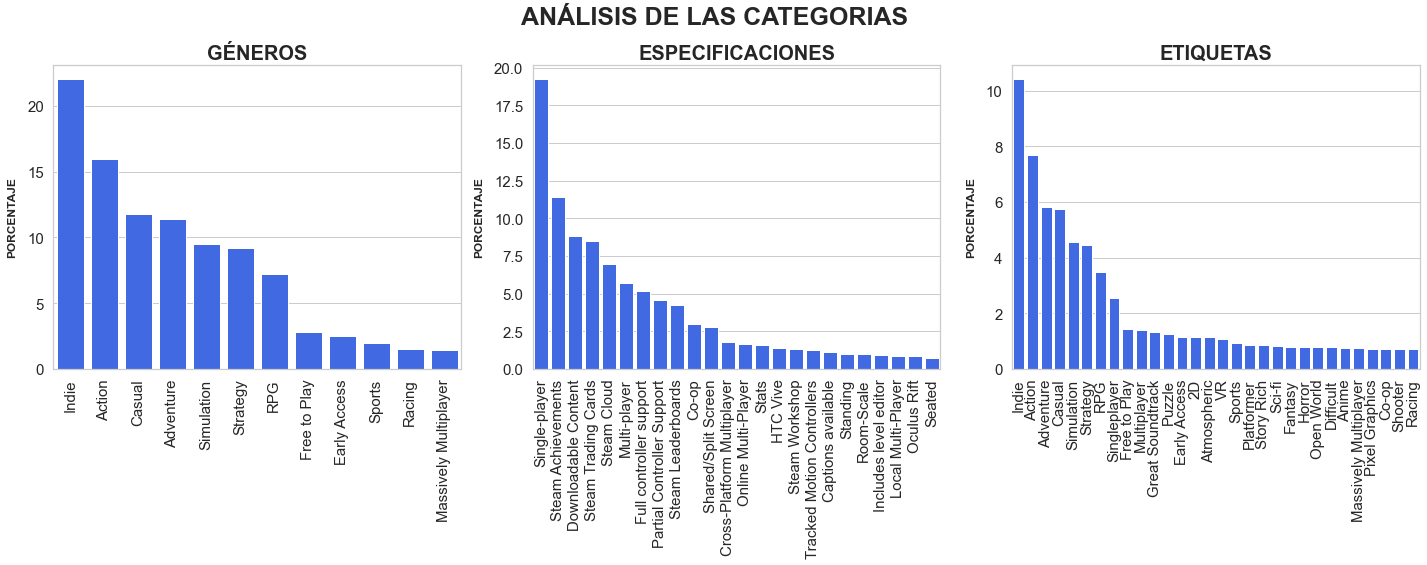

In [223]:
graficar_categorias(0.7)

El atributo ```Etiquetas``` merece un trato especial ya que contiene información que se encuentra en los otros dos atributos. En este caso, principalmente es importante conocer que información nueva puede aportarnos dicho atributo.

In [13]:
specs = get_data('Especificaciones')[1]
genres = get_data('Géneros')[1]
data, tags = get_data('Etiquetas')
tags = list(set(list(set(tags) - set(specs))) - set(genres))

total_cantidad = data['cantidad'].sum()
mask = data.isin(tags).loc[:,'Etiquetas']
data = data[mask].sort_values('cantidad', ascending=False)
data.head()

,Etiquetas,cantidad
261,Singleplayer,4343
183,Multiplayer,2383
128,Great Soundtrack,2233
223,Puzzle,2111
3,2D,1944


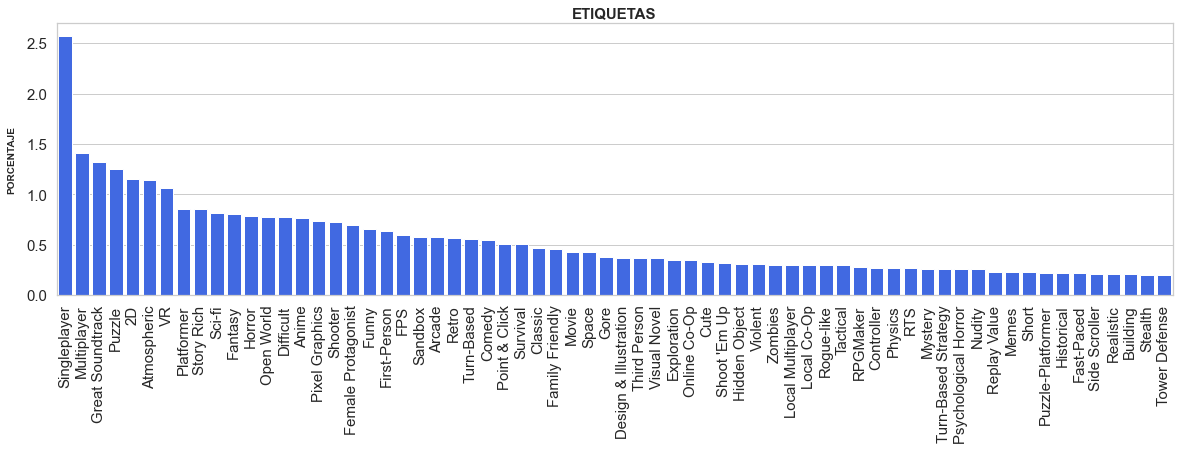

In [14]:
data = data.pivot_table(values='cantidad', index='Etiquetas',
                                aggfunc={ 'cantidad': lambda x: x*100/total_cantidad.sum() })
data = data.reset_index(drop=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Etiquetas', y='cantidad', color='Royalblue', data=data.query('cantidad >= 0.20'),
            order=data.query('cantidad >= 0.20').sort_values('cantidad', ascending=False).Etiquetas,
            saturation=1)
plt.tick_params(axis='both', labelsize=15)
plt.tick_params(axis='x', rotation=90)
plt.title('Etiquetas'.upper(), fontsize=15, fontweight='bold')
plt.xlabel('')
plt.ylabel('Porcentaje'.upper(), fontsize=10, labelpad=10, weight='bold')
plt.show()

Podemos observar en la gráfica de datos perteneciente al atributo ```Etiquetas``` que en la misma contenemos datos que a apenas superan el 2.5% del total. Además, habiendo realizado un filtrado de valores únicos *—datos nuevos que aporta la categoría—* respecto a los otros atributos, encontramos que de nuestro top tres, solo el tercero es información nueva respecto a la que contenemos en los atributos ```Géneros``` y ```Especificaciones```. El mismo no logra superar el 1.5% del total.

*Esta categoría no aporta información nueva de forma significativa*, pero, si nos remitimos a nuestro análisis inicial de valores faltantes, nos encontramos que este atributo es el que menos datos faltantes posee. Por lo tanto, nos ayudaría a rellenar los valores faltantes que no tienen los otros atributos.


Evaluamos cuantos datos podemos completar en la categoría ```Géneros``` y ```Especificaciones```.

In [23]:
genres = games.query('Géneros.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { genres.shape[0] } registros a completar en la categoría GÉNEROS')
genres.head()

Existen 3144 registros a completar en la categoría GÉNEROS


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
4,773570,Log Challenge,<NA>,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN,NaN
11,724910,Icarus Six Sixty Six,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...",[Casual],http://store.steampowered.com/app/724910/Icaru...,False,Free,NaN,NaN
19,772590,After Life VR,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Indie, VR]",http://store.steampowered.com/app/772590/After...,True,4.99,NaN,NaN
20,640250,Kitty Hawk,<NA>,NaN,NaN,"[Single-player, Steam Leaderboards, HTC Vive, ...","[Early Access, Action, Adventure, Indie, Casual]",http://store.steampowered.com/app/640250/Kitty...,True,2.99,NaN,NaN
22,711440,Mortars VR,<NA>,NaN,NaN,"[Single-player, Multi-player, Online Multi-Pla...","[Early Access, Strategy, Action, Indie, Casual...",http://store.steampowered.com/app/711440/Morta...,True,0.99,8 user reviews,NaN


In [24]:
specs = games.query('Especificaciones.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { specs.shape[0] } registros a completar en la categoría ESPECIFICACIONES')
specs.head()

Existen 660 registros a completar en la categoría ESPECIFICACIONES


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
26,777910,Robotpencil Presents: Understanding 3D for Con...,<NA>,2018-01-03,NaN,NaN,"[Design & Illustration, Tutorial]",http://store.steampowered.com/app/777910/Robot...,False,4.99,NaN,NaN
738,48220,Might & Magic: Heroes VI,Blackhole,2011-10-13,"[RPG, Strategy]",NaN,"[Strategy, RPG, Turn-Based Strategy, Turn-Base...",http://store.steampowered.com/app/48220/Might_...,False,19.99,Mixed,77
873,206760,Painkiller: Recurring Evil,Med-Art,2012-02-29,[Action],NaN,"[Action, FPS]",http://store.steampowered.com/app/206760/Paink...,False,9.99,Mixed,38
1793,257610,LogoMaker 4,Studio V5,2013-12-04,[Design &amp; Illustration],NaN,[Design & Illustration],http://store.steampowered.com/app/257610/LogoM...,False,29.99,Mixed,NaN
1828,262650,RaySupreme 3D,BrainDistrict,2013-12-16,[Animation &amp; Modeling],NaN,[Animation & Modeling],http://store.steampowered.com/app/262650/RaySu...,False,39.99,Mostly Negative,NaN


Realizamos las imputaciones de los datos faltantes y vemos cuáles quedaron fuera.

In [25]:
val_genres = completar(genres, 'Géneros')
val_specs = completar(specs, 'Especificaciones')

print('DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES')
val_genres = list(map(str.lower, np.unique(val_genres, return_counts=False)))
print('\nEtiquetas que quedaron afuera para géneros:\n', val_genres)
val_specs = list(map(str.lower, np.unique(val_specs, return_counts=False)))
print('\nEtiquetas que quedaron afuera para especificaciones:\n', val_specs)

DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES

Etiquetas que quedaron afuera para géneros:
 ['1980s', "1990's", '2d', '360 video', '3d platformer', '3d vision', 'action rpg', 'action-adventure', 'aliens', 'animation & modeling', 'anime', 'arcade', 'assassin', 'based on a novel', 'basketball', "beat 'em up", 'bullet hell', 'cartoon', 'character customization', 'chess', 'cinematic', 'classic', 'cold war', 'comedy', 'comic book', 'controller', 'crime', 'cute', 'cyberpunk', 'dark comedy', 'dark fantasy', 'dating sim', 'demons', 'design & illustration', 'detective', 'difficult', 'documentary', 'dragons', 'drama', 'episodic', 'fps', 'faith', 'family friendly', 'fantasy', 'female protagonist', 'football', 'foreign', 'funny', 'futuristic', 'game development', 'gaming', 'gore', 'great soundtrack', 'hack and slash', 'hacking', 'hardware', 'hidden object', 'historical', 'horror', 'illuminati', 'isometric', 'jrpg', 'kickstarter', 'local multiplayer', 'mmorpg', 'magic', 'm

Luego de haber aplicado correctamente las funciones que se crearon, podemos observar que existen valores faltantes en las columnas que planeabamos completar. Esto sucede ya que la información que proporciona la columna ```Etiquetas``` no pertenece a ninguna columna, es decir, son datos nuevos.

In [25]:
total = games.query('Especificaciones.isna() | Géneros.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde no se pudieron realizar las imputaciones.')
games.query('Especificaciones.isna() | Géneros.isna()', engine='python').sample(10)

Existen 1379 registros donde no se pudieron realizar las imputaciones.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
6618,275030,Punch! ViaCAD 2D/3D v9 + 3D Printing PowerPack LT,Evolution Software,2016-07-13,"[Animation &amp; Modeling, Design &amp; Illust...",NaN,"[Design & Illustration, Animation & Modeling]",http://store.steampowered.com/app/275030/Punch...,False,99.99,9 user reviews,NaN
18142,609500,Comedy Dynamics: Coming to The Stage,<NA>,2015-05-06,NaN,[Captions available],[Episodic],http://store.steampowered.com/app/609500/Comed...,False,29.99,NaN,NaN
15016,726400,Aliens: Zone-X,<NA>,2016-08-25,NaN,[Captions available],[Movie],http://store.steampowered.com/app/726400/Alien...,False,4.99,NaN,NaN
17050,668180,Ghost Ship,<NA>,NaN,NaN,"[HTC Vive, Oculus Rift, Tracked Motion Control...","[360 Video, Short]",http://store.steampowered.com/app/668180/Ghost...,False,Free,3 user reviews,NaN
14586,734190,GAMERS!,<NA>,2017-10-26,NaN,NaN,"[Episodic, Anime]",http://store.steampowered.com/app/734190/GAMERS/,False,1.99,4 user reviews,NaN
18505,615720,Jimmy Dore: Sentenced to Live,<NA>,2011-09-26,NaN,[Captions available],[Movie],http://store.steampowered.com/app/615720/Jimmy...,False,3.99,1 user reviews,NaN
11899,728520,Still Breathing,<NA>,1998-05-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/728520/Still...,False,4.99,NaN,NaN
23413,421440,Rounders,<NA>,1999-02-09,NaN,[Captions available],"[Movie, Drama, Crime]",http://store.steampowered.com/app/421440/Round...,False,3.99,NaN,NaN
23073,459480,Leap of Fate - Soundtrack,Vibe Avenue,2016-05-20,NaN,[Downloadable Content],NaN,http://store.steampowered.com/app/459480/Leap_...,False,3.99,1 user reviews,NaN
8877,597800,Eugene Mirman: Vegan On His Way To The Complai...,<NA>,2015-07-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/597800/Eugen...,False,3.99,NaN,NaN


Verificamos los valores nulos que no pueden ser completados ya que, la columna ```Género``` posee datos faltantes, la columna ```Especificaciones``` posee datos faltantes y la columna ```Etiquetas``` también posee datos faltantes.

In [26]:
total = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde las tres columnas son nulas.')
games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python')

Existen 7 registros donde las tres columnas son nulas.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
5373,382990,BrainBread 2 Mod Tools,<NA>,2016-02-17,NaN,NaN,NaN,http://store.steampowered.com/app/382990/Brain...,False,NaN,NaN,NaN
9560,582400,Alien Swarm: Reactive Drop Dedicated Server,<NA>,2017-04-20,NaN,NaN,NaN,http://store.steampowered.com/app/582400/Alien...,False,NaN,NaN,NaN
21335,531340,Steam Controller Skin - CSGO Blue/Orange,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531340/Steam...,False,9.99,NaN,NaN
21336,531360,Steam Controller Skin - CSGO Grey Camo,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531360/Steam...,False,9.99,NaN,NaN
21337,531430,Steam Link Skin - CSGO Blue/Orange,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531430/Steam...,False,9.99,NaN,NaN
23326,451330,IS Defense Editor,<NA>,2016-04-29,NaN,NaN,NaN,http://store.steampowered.com/app/451330/IS_De...,False,NaN,6 user reviews,NaN
27738,338440,BOMB Dedicated Server,<NA>,2014-12-17,NaN,NaN,NaN,http://store.steampowered.com/app/338440/BOMB_...,False,NaN,NaN,NaN


Inicialmente, eliminamos estos registros y luego procedemos a eliminar aquellos valores nulos de las listas luego de haber creado una única variable que agrupe los datos de las tres categorías.

In [26]:
idx = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').index
games.drop(idx, inplace=True)

Llenamos los valores nulos de nuestras categorías con listas vacias y formateamos las cadenas de caracteres de nuestros atributos categóricos con la finalidad de eliminar apóstrofes, mayúsculas, guiones medios, etc.

In [27]:
for column in ['Géneros', 'Especificaciones', 'Etiquetas']:
    games[column].fillna({ i: [] for i in games.index }, inplace=True)
    games[column] = games[column].map(lambda x: [ re.sub(r'[^\w\s]', '', item).lower() for item in x])

---
**PRECIO**

---

Por útlimo, analizamos el atributo precio.

In [28]:
precios = np.array([i for i in list(games.Precio) if (type(i) == str)])
np.unique(precios)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Free to Try',
       'Free to Use', 'Install Now', 'Install Theme', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo',
       'Starting at $449.00', 'Starting at $499.00', 'Third-party'],
      dtype='<U29')

Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuales gratuitos.

In [29]:
games['Precio'] = games.Precio.apply(lambda p: 'Paid' if (type(p) == float or p.startswith('Starting')) else 'Free')
games['Precio'] = games['Precio'].astype('category')
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[action, casual, indie, simulation, strategy]",[singleplayer],"[strategy, action, indie, casual, simulation]",http://store.steampowered.com/app/761140/Lost_...,False,Paid,NaN,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[free to play, indie, rpg, strategy]","[singleplayer, multiplayer, online multiplayer...","[free to play, strategy, indie, rpg, card game...",http://store.steampowered.com/app/643980/Ironb...,False,Free,Mostly Positive,NaN
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[casual, free to play, indie, simulation, sports]","[singleplayer, multiplayer, online multiplayer...","[free to play, simulation, sports, casual, ind...",http://store.steampowered.com/app/670290/Real_...,False,Free,Mostly Positive,NaN
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[action, adventure, casual]",[singleplayer],"[action, adventure, casual]",http://store.steampowered.com/app/767400/2222/,False,Paid,NaN,NaN
4,773570,Log Challenge,<NA>,NaN,"[sports, indie, action, casual]","[singleplayer, full controller support, htc vi...","[action, indie, casual, sports]",http://store.steampowered.com/app/773570/Log_C...,False,Paid,NaN,NaN


Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuáles gratuitos.

In [31]:
games.isna().sum()

GameID                   0
Aplicación               0
Desarrollador         3288
Fecha lanzamiento     2064
Géneros                  0
Especificaciones         0
Etiquetas                0
Url                      0
Acceso previo            0
Precio                   0
Sentimiento           7173
Metascore            29447
dtype: int64

#### Análisis de variables categóricas

Analizamos las variables categóricas con el fín de pulir los datos y que los mismos tengan consistencia. De aquí, se puede observar que los atributos que destacan son: ```Géneros```, ```Etiquetas```, ```Especificaciones```, ```Precio``` y ```Acceso previo```.

---
**Géneros, etiquetas y especificaciones**

---
En estos tres atributos, los registros contienen listas en sus campos; necesitamos crear una columna única que extraiga las carácteristicas de cada registro.

In [30]:
games['Categorías'] = games['Especificaciones'] + games['Etiquetas'] + games['Géneros']
games['Categorías'] = [np.unique(category) for category in games.Categorías]
#games.explode('Categorías').dropna(subset=['Categorías'], inplace=True)

In [31]:
np.unique(list(itertools.chain(*games['Categorías'])))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

Estos son las características únicas que poseen cada videojuegos. Llegado a este punto se puede realizar un filtrado eliminando buscando videojuegos, aplicaciones de edición, etc.

Eliminamos las columnas ```Géneros```, ```Especificaciones``` y ```Etiquetas```. Adicionalmente, también eliminamos la columna ```Url``` ya que cumplió su proposito en el análisis de duplicados.

In [32]:
games.drop(columns=['Géneros', 'Especificaciones', 'Etiquetas', 'Url'], inplace=True)
games.sample(5)

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Acceso previo,Precio,Sentimiento,Metascore,Categorías
26873,367810,Sky Force Anniversary - Original Soundtrack,Infinite Dreams,2015-04-30,False,Paid,6 user reviews,NaN,"[action, downloadable content, full controller..."
17361,648420,Town of Salem - Original Sound Track,BlankMediaGames,2017-06-01,False,Paid,8 user reviews,NaN,"[crossplatform multiplayer, downloadable conte..."
20415,529260,Robot Incursion,<NA>,NaN,False,Paid,2 user reviews,NaN,"[action, htc vive, roomscale, singleplayer, st..."
26859,362490,Exanima,Bare Mettle Entertainment,2015-04-29,True,Paid,Very Positive,NaN,"[action, action rpg, adventure, atmospheric, c..."
27624,342610,HyperRogue,Zeno Rogue,2015-01-16,False,Paid,Very Positive,NaN,"[coop, education, includes level editor, indie..."


In [37]:
games.drop(columns=['Sentimiento', 'Metascore'], inplace=True)
games.reset_index(drop=True, inplace=True)
games['Aplicación'] = games['Aplicación'].astype('string')
games['Acceso previo'] = games['Acceso previo'].astype('category')
games['GameID'] = games['GameID'].astype('uint32')
games['Precio'] = games['Precio'].astype('category')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32122 entries, 0 to 32121
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GameID             32122 non-null  uint32  
 1   Aplicación         32122 non-null  string  
 2   Desarrollador      28834 non-null  string  
 3   Fecha lanzamiento  30058 non-null  object  
 4   Acceso previo      32122 non-null  category
 5   Precio             32122 non-null  category
 6   Categorías         32122 non-null  object  
dtypes: category(2), object(2), string(2), uint32(1)
memory usage: 1.2+ MB


## **Análisis de Datasets**

En esta sección se pretende analizar los dataset para entender los mismos y extraer información que nos puede ayudar a generar un mejor *sistema de recomendación*.

### Merge

Hacemos el unificado de los datasets a través de la columna ```GameID```, que poseen en común.

In [38]:
reviews_games = reviews.merge(games, how='left', left_on='GameID', right_on='GameID',
                              suffixes=('REVIEWS_', 'GAMES'))
columns = ['Usuario', 'Cant. horas', 'Cant. juegos', 'Fecha', 'Comentario', 'GameID', 'Aplicación', 'Precio', 'Categorías']
reviews_games[columns].head()

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID,Aplicación,Precio,Categorías
0,Poppie csgolive.com hellcase.com,84.099998,11,2018-01-05,i hate this game cause i always get csgo'ed an...,730,Counter-Strike: Global Offensive,Paid,"[action, competitive, coop, difficult, esports..."
1,I want to DIE,87.099998,62,2018-01-05,CSGO a Multiplayer Game which there is many Ga...,730,Counter-Strike: Global Offensive,Paid,"[action, competitive, coop, difficult, esports..."
2,Odin,121.500000,7,2018-01-05,Too much cheaters for the price of ca. 15$.,730,Counter-Strike: Global Offensive,Paid,"[action, competitive, coop, difficult, esports..."
3,Razoff the pestilent,24.200001,82,2018-01-05,The best expansion of Dawn of War and in my op...,9450,"Warhammer® 40,000: Dawn of War® - Soulstorm",Paid,"[action, adventure, atmospheric, base building..."
4,Clem,2.200000,11,2018-01-05,"Not complaining, I LOVE this game. Got separat...",587450,Saurian,Paid,"[dinosaurs, early access, indie, multiplayer, ..."


Verificamos que los registros correspondientes a los comentarios de los usuarios estén haciendo referencia a un producto que tengamos en nuestro dataset de videojuegos.

In [39]:
reviews_games[columns].isna().sum()

Usuario         0
Cant. horas     0
Cant. juegos    0
Fecha           0
Comentario      0
GameID          0
Aplicación      0
Precio          0
Categorías      0
dtype: int64

### Reviews

Realizamos algunas visualizaciones para entender nuestros datos.

---
**TOP 10: Juegos con mayor promedio de horas**

---

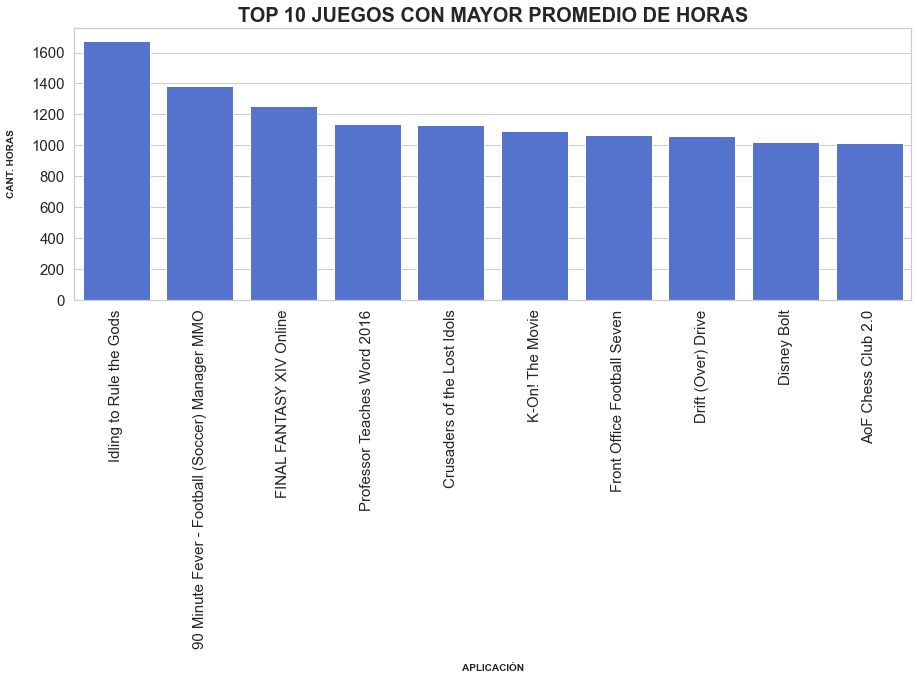

In [46]:
data = reviews_games.pivot_table(values=['Usuario', 'Cant. horas'], index=['GameID', 'Aplicación'],
                                 aggfunc={ 'Usuario': 'count', 'Cant. horas': np.mean }).sort_values('Cant. horas',
                                                                                                     ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Aplicación', y='Cant. horas', data=data, color='Royalblue')
plt.title('Top 10 juegos con mayor promedio de horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xticks(rotation=90)
plt.ylabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.show()

---
**Análisis de las horas respecto al TOP 10 de juegos con mayor promedio de horas**

---

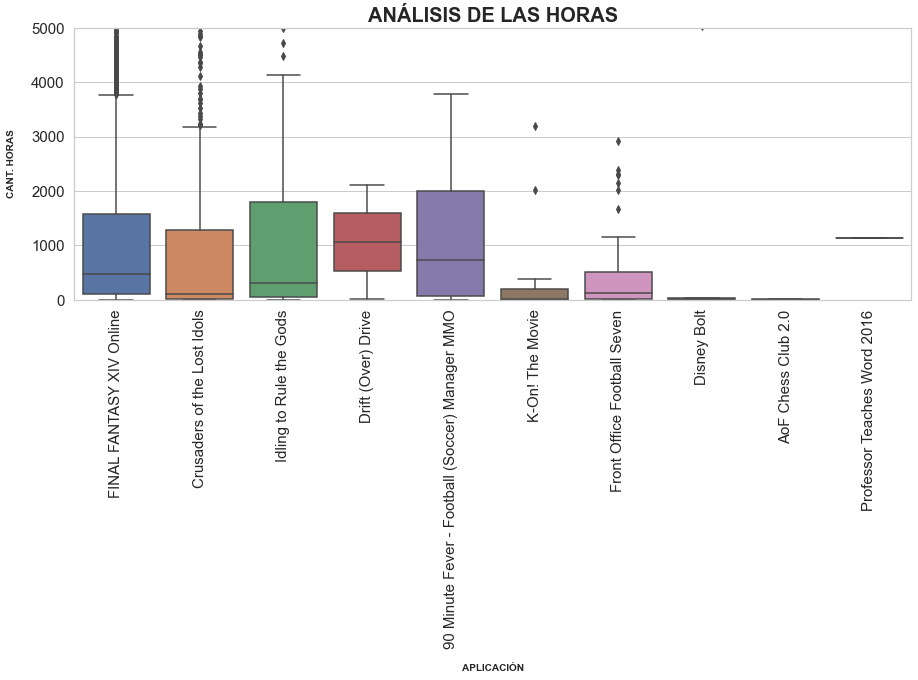

In [82]:
idx = data.GameID
mask = reviews_games['GameID'].isin(idx)
reviews_games[mask]

plt.figure(figsize=(15,5))
sns.boxplot(x='Aplicación', y='Cant. horas', data=reviews_games[mask])
plt.title('Análisis de las horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xticks(rotation=90)
plt.ylabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylim(0,5000)
plt.show()

---
**TOP 10: Usuario con más comentarios**

---

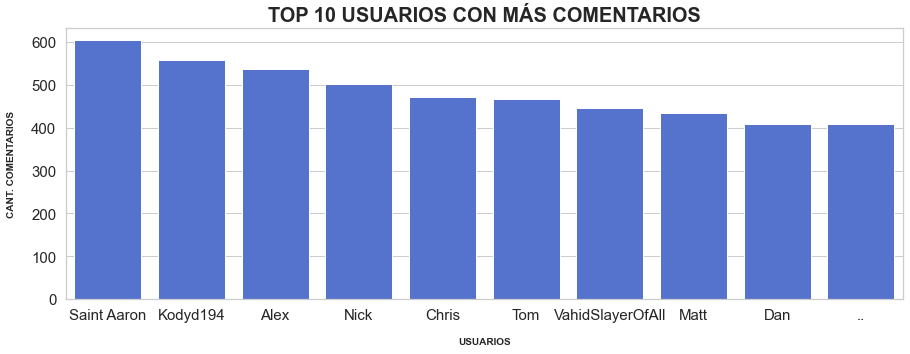

In [64]:
data = reviews.groupby('Usuario').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count'))\
                                 .sort_values('Comentarios', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Usuario', y='Comentarios', data=data, color='Royalblue')
plt.title('Top 10 usuarios con más comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Cant. comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.show()

---
**TOP 10: Juegos con más comentarios**

---

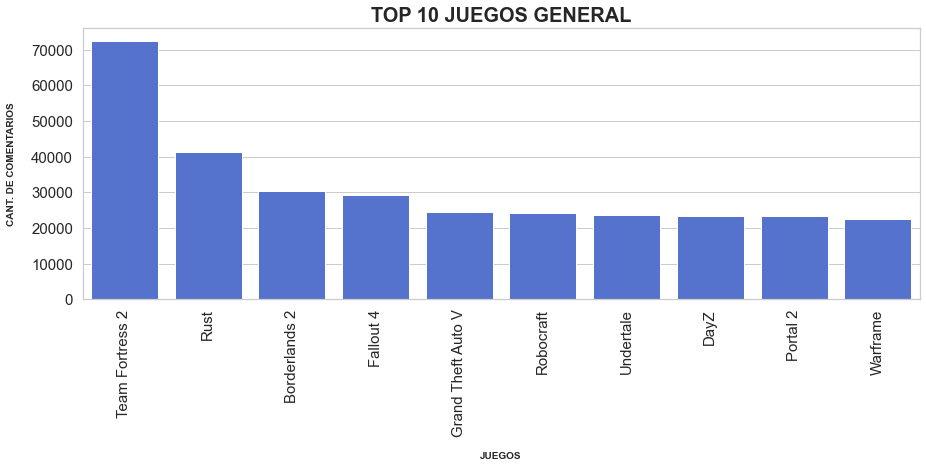

In [65]:
data = reviews_games.groupby('Aplicación').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count'))\
                                          .sort_values('Comentarios', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Aplicación', y='Comentarios', data=data, color='Royalblue')
plt.title('Top 10 juegos general'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Juegos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Cant. de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xticks(rotation=90)
plt.show()

---
**TOP 10: Juegos pagos con más comentarios**

---

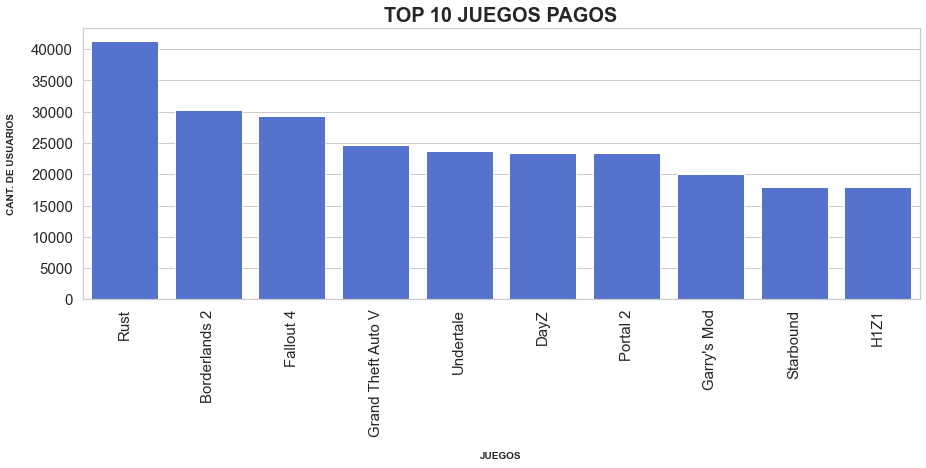

In [67]:
data = reviews_games.query('Precio == "Paid"').groupby('Aplicación').agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                                              aggfunc='count'))\
                                              .sort_values('Usuarios', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Aplicación', y='Usuarios', data=data, color='Royalblue')
plt.title('Top 10 juegos pagos'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Juegos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Cant. de usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xticks(rotation=90)
plt.show()

---
**TOP 10: Juegos gratis con más comentarios**

---

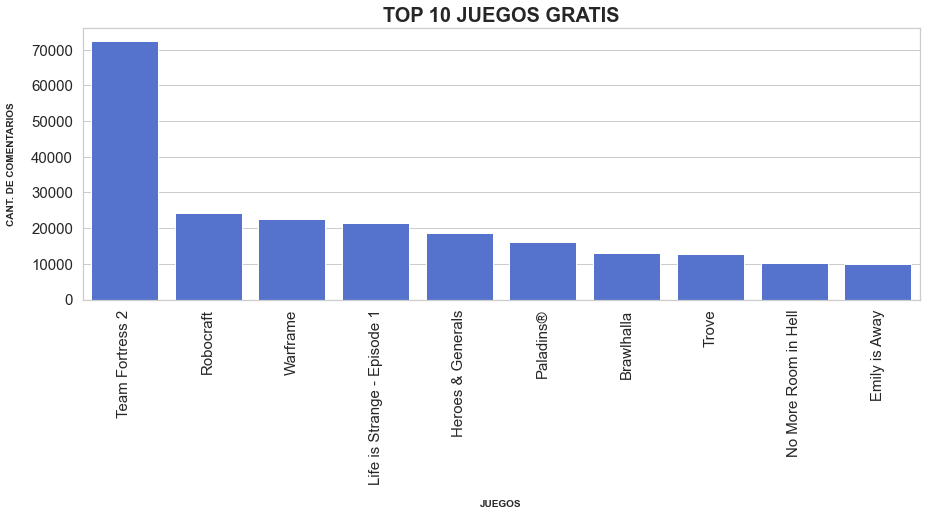

In [68]:
data = reviews_games.query('Precio == "Free"').groupby('Aplicación').agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                                              aggfunc='count'))\
                    .sort_values('Usuarios', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Aplicación', y='Usuarios', data=data, color='Royalblue')
plt.title('Top 10 juegos gratis'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Juegos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Cant. de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xticks(rotation=90)
plt.show()

---
**Proporcionalidad de comentarios conforme a precio del videojuego**

---

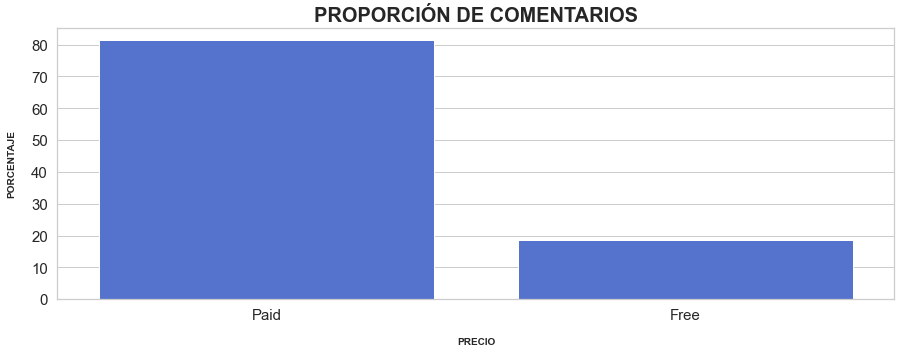

In [69]:
data = reviews_games.groupby('Precio').agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                aggfunc=lambda x:len(x)/len(reviews_games)*100))
data.reset_index(inplace=True)

plt.figure(figsize=(15,5))
sns.barplot(x='Precio', y='Usuarios', data=data, color='Royalblue',
            order=data.sort_values('Usuarios', ascending=False).Precio)
plt.title('Proporción de comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.show()

### Games


---
**Juegos según tipo de acceso**

---

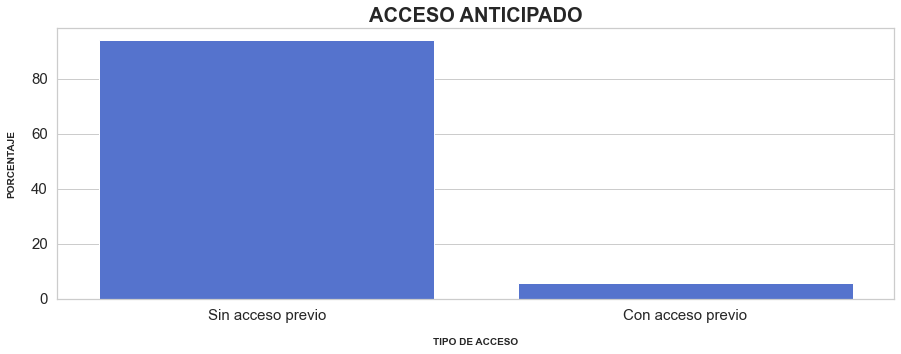

In [237]:
group_data = games.groupby(by='Acceso previo').agg(Porcentaje=pd.NamedAgg(column='GameID',
                                               aggfunc=lambda x: len(x)/len(games)*100))
group_data.reset_index(inplace=True)

plt.figure(figsize=(15,5))
sns.barplot(x='Acceso previo', y='Porcentaje', data=group_data, color='Royalblue')
plt.tick_params(axis='both', labelsize=15)
plt.title('Acceso anticipado'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('Tipo de acceso'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.xticks([True, False], ('Con acceso previo', 'Sin acceso previo'), ha='center')
plt.ylabel('Porcentaje'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.yticks(va='center')
plt.show()

---
**Juegos según el precio**

---

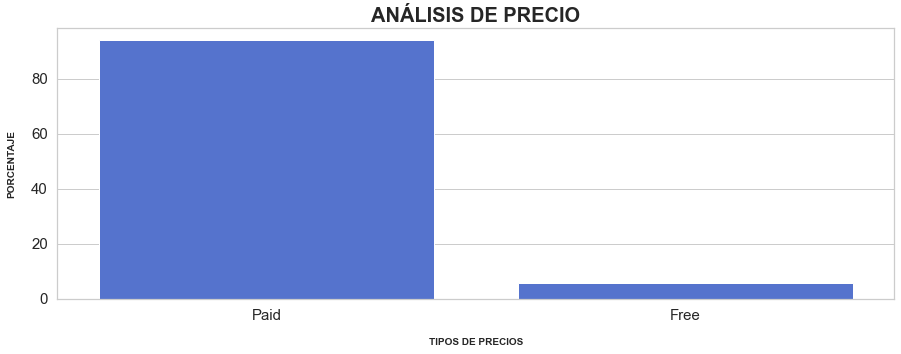

In [238]:
group_data = games.groupby(by='Precio').agg(Porcentaje=pd.NamedAgg(column="GameID",
                                                                   aggfunc=lambda x: len(x)/len(games)*100))
group_data.reset_index(inplace=True)
plt.figure(figsize=(15,5))
sns.barplot(x='Precio', y='Porcentaje', data=group_data, color='Royalblue',
            order=group_data.sort_values('Porcentaje', ascending=False).Precio)
plt.tick_params(axis='both', labelsize=15)
plt.title('Análisis de precio'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('Tipos de precios'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.xticks(ha='center')
plt.ylabel('Porcentaje'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.yticks(va='center')
plt.show()

---
**Categorías que se encuentran en al menos el 5% de nuestros registros**

---

In [83]:
def one_dimension(series):
    return pd.Series([x for _list in series for x in _list], name='Categorías').value_counts()

data = one_dimension(games['Categorías']).apply(lambda x: x*100/len(games)).round(2)
mask = data.values > 5

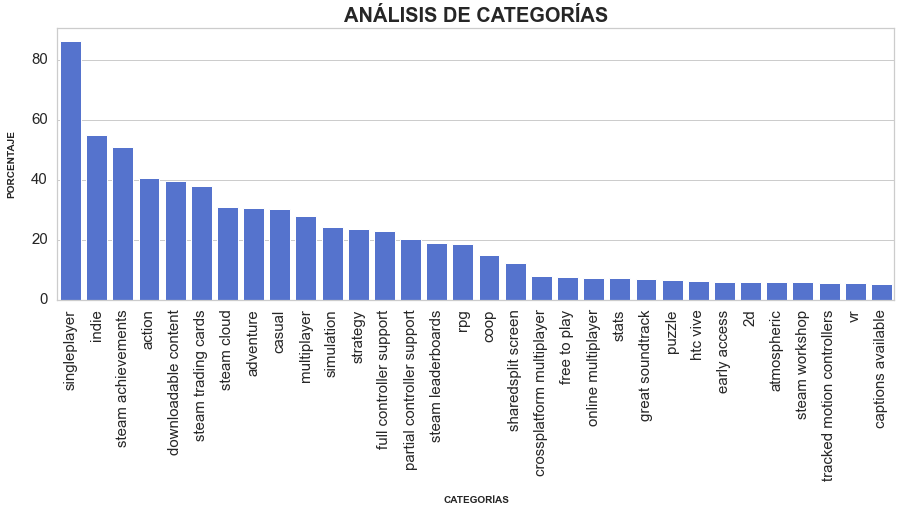

In [84]:
plt.figure(figsize=(15,5))
sns.barplot(x=data[mask].index, y=data[mask].values, color='Royalblue')
plt.tick_params(axis='both', labelsize=15)
plt.title('Análisis de categorías'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('Categorías'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.xticks(ha='center', rotation=90)
plt.ylabel('Porcentaje'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.yticks(va='center')
plt.show()

## **Sistemas de recomendación**

### Benchmark

Como modelo benchmark, podemos recomendar los videojuegos de nuestro TOP 10 donde los usuarios tienen mayor promedio de horas jugando.

Existen ocasiones donde un nuevo juego o artículo se estrena y este mismo no posee calificaciones; a esta situación se la denomina ***COLD START***. En este caso, por medio de los metadatos que conseguimos del juego o artículo en cuestión, generamos proximidad a otros juegos/artículos.

Este primer acercamiento, basado en un sistema de recomendación por contenido, nos sirve para poder generar recomendaciones a través de los metadatos que podemos encontrar en nuestro dataset de cada artículo.

In [131]:
games.reset_index(drop=True, inplace=True)
games.head()
dummies = .apply(pd.Series).stack().str.get_dummies().sum(level=0)

In [136]:
categories = games['Categorías'].apply(pd.Series)
cols = categories.columns.tolist()
dummies = pd.DataFrame()
for col in cols:
    if dummies.empty:
        dummies = pd.get_dummies(categories[col])
    else:
        dummies.add(pd.get_dummies(categories[col]))

In [149]:
cat = data[mask].index
dummies.loc[:,cat.values]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['steam trading cards', 'steam cloud', 'steam leaderboards', 'puzzle',\n       'steam workshop', 'tracked motion controllers', 'vr'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

Visualizamos el shape de nuestra matriz

In [112]:
dummies.drop(columns=[ 'Animation &amp; Modeling', 'Audio Production', 'Captions available', 'Commentary available',
                       'Design &amp; Illustration', 'Early Access', 'Includes Source SDK', 'Includes level editor',
                       'Mods (require HL1)', 'Mods (require HL2)', 'Partial Controller Support', 'Photo Editing',
                       'Seated', 'Software Training', 'Standing', 'Steam Turn Notifications', 'Video Production',
                       'Web Publishing' ], inplace=True)
dummies.shape

(30752, 43)

In [120]:
dummies.head()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Downloadable Content,Education,Free to Play,Full controller support,Game demo,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Workshop,SteamVR Collectibles,Strategy,Tracked Motion Controllers,Utilities,Valve Anti-Cheat enabled,Windows Mixed Reality
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Generamos nuestra matriz de distancias utilizando la similitud del coseno.

In [118]:
similitudes = cosine_similarity(dummies, dummies, dense_output=False)
similitudes.shape

Creamos una función de recomendaciones

In [145]:
index = pd.Series(games['GameID'])
def recomendations(game_index, simil=similitudes):
    recomendations = []
    idx = index[index == game_index].index[0]
    scores = pd.Series(simil[idx]).sort_values(ascending=False)
    top_ten = list(scores.iloc[1:11].index)

    for i in top_ten:
        recomendations.append(list(games.Aplicación)[i])
    return recomendations

print(recomendations("706030"))

['the Breath.', 'Production Inc.', 'Finger Ninja', 'Puzzle Mania', 'Yatzy', 'Pony World 2', 'Solitaire', 'Dream Daddy: A Dad Dating Simulator', 'Retro Pinball', 'Joy Pony']


En este sistema de recomendación basado en contenido no tomamos en cuenta ningún tipo de calificación que cada usuario realiza sobre un juego, únicamente nos basamos en el contenido y los metadatos intrínsecos de cada videojuego.

### Sistema de recomendación: Basado en contenido

Implementamos un motor de recomendación utilizando un filtro basado en contenido. Hacemos uso de la librería ```Implicit```, la cuál, nos ayuda en una problemática que se puede ver a lo largo de todo nuestro análisis: carecemos de un puntaje explícito por parte de los usuarios.

#### Implicit ratings

De acuerdo al análisis de nuestros datos, corroboramos la ausencia de un rating o feedback explícito en formato número por parte de los usuarios. Contamos con dos aproximaciones a lo que se puede considerar un rating: *un feedback escrito* y un atributo donde *el usuario califica que tan divertido es un juego*, este no nos puede ayudar porque tiene mucha presencia de valores nulos.

In [142]:
samples = sample_without_replacement(method='tracking_selection', n_population=reviews_games.shape[0], n_samples=1000000,
                                     random_state=10)
rg = reviews_games.loc[samples,:]

In [143]:
horas = rg['Cant. horas'].values
scale = RobustScaler().fit_transform(horas.reshape(-1,1))
rg['Cant. horas SCALE'] = scale

Tomamos 1.000.000 de registros para evitar problemas en el procesamiento de nuestros datos. Creamos matrices dispersas utilizando la cantidad de horas que un usuario pasa en un juego como punto de partidad para establecer un interés del mismo con un juego/producto, lo basamos en la premisa de que si un juego no es divertido uno no lo juega.

Creamos nuestras matrices dispersas.

In [144]:
sparse_item_user = sparse.csr_matrix((rg['Cant. horas SCALE'], (rg['GameID'], rg.index)))
sparse_user_item = sparse.csr_matrix((rg['Cant. horas SCALE'], (rg.index, rg['GameID'])))

Instanciamos un modelo ALS.

In [145]:
alpha = 15
train, test = evaluation.train_test_split((sparse_item_user*alpha).astype('double'), train_percentage=.66)

als = AlternatingLeastSquares(factors=20, iterations=25, random_state=10, regularization=.1)
als.fit(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluamos nuestro modelo con la métrica *AUC*.

In [146]:
evaluation.AUC_at_k(als, train, test, show_progress=False)
print('AUC: %s' %round(auc, 4))

AUC: 0.5


Obtenemos un valor de **AUC de 0.5**. Este valor nos da la pauta que nuestro modelo está realizando predicciones sin sustento en los datos.

Creamos una función para obtener las recomendaciones utilizando el algoritmo ALS.

In [147]:
def recomendaciones(videojuego):
    user_items = sparse_user_item.T.tocsr()
    recom = als.recommend(videojuego, user_items, 10)
    idx = [r[0] for r in recom]
    scr = [r[1] for r in recom]
    apps = games.query('GameID == @idx').Aplicación
    print(recom)
    rec = pd.DataFrame(scr, index=apps, columns=['Score'])
    return rec

#print(recomendacion)
#for item, score in recomendacion:
#print('Producto: %(id)s - Puntaje: %(score)s' %{ 'id': item, 'score': score.round(2) })
#print('------------------------------------------------')
#print('TOP 10: Productos basados en filtro colaborativo')
#print('------------------------------------------------')

Únicamente, lo que resta es buscar un juego y obtener las recomendaciones.

In [149]:
recomendaciones(730)
#rg.head()

[(260241, 0.0), (260239, 0.0), (260237, 0.0), (260238, 0.0), (260269, 0.0), (260224, 0.0), (260222, 0.0), (260272, 0.0), (260273, 0.0), (260274, 0.0)]


ValueError: Shape of passed values is (10, 1), indices imply (0, 1)

In [116]:
# 219441, 758210, 94304, 326670
#final_data.isna().sum()
reviews_games[columns][reviews_games.Usuario.str.contains('[^\u0001-\u007F]{3,}')]

#username = reviews_games.Usuario.values
#username = reviews_games.Usuario.str.encode('utf-8')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID,Aplicación,Géneros,Especificaciones
22,✦Димитрис✦,1.6,66.0,2018-01-05,"Fun game, wierdly addictive, would reccomend",217100,Dementium II HD,"[Action, Adventure, Indie]","[Single-player, Steam Achievements, Full contr..."
33,空白《叶秋》,254.0,19.0,2018-01-05,Very fun XD lmao,359550,Tom Clancy's Rainbow Six® Siege,[Action],"[Single-player, Multi-player, Co-op, Steam Tra..."
143,ШопскиСРБ,41.8,44.0,2018-01-05,Great survival game with good story !The game ...,242760,The Forest,"[Action, Adventure, Indie, Simulation, Early A...","[Single-player, Multi-player, Co-op, Steam Cloud]"
201,ℳ𝓻.𝓦𝓸𝓵𝒇𝓲𝒆,115.7,131.0,2018-01-05,"If you don't enjoy farming/grinding, this is n...",230410,Warframe,"[Action, Free to Play]","[Single-player, Multi-player, Co-op, Steam Tra..."
208,Неки лик,17.2,8.0,2018-01-05,"Tried to play 5 times, still cant get the feel...",230410,Warframe,"[Action, Free to Play]","[Single-player, Multi-player, Co-op, Steam Tra..."
...,...,...,...,...,...,...,...,...,...
3654541,Cyriel ᛭ᚲᛃᚱᛁᛖᛚ᛭,6.6,825.0,2010-11-02,Hell yes people. Just yes.,39800,Nation Red,"[Action, Indie]","[Single-player, Multi-player, Online Multi-Pla..."
3654543,Вежливый из Крыма (РФ),0.1,374.0,2010-11-01,That's an awesome game! Must Have! Played in 2...,11480,Soldiers: Heroes of World War II,[Strategy],"[Single-player, Multi-player, Co-op]"
3654640,Белый охотник,32.3,109.0,2010-10-17,i just love it!,630,Alien Swarm,[Action],"[Single-player, Multi-player, Co-op, Steam Ach..."
3654654,ﾚ҉.̠̪͎̯̮ͤ͛̋̀͆ͮ̐7,0.9,730.0,2010-10-17,Oddly entertaining.,11370,Nikopol: Secrets of the Immortals,"[Adventure, Indie]",[Single-player]


In [119]:
#print(reviews_games.Usuario.str.encode(encoding="utf-8"))
reviews_games[reviews_games['Usuario']=='null'].shape

(44, 17)